#***Student Name: Ji Qi*** , ***Session B1***



### Import packages

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Model preparation

## Basic Info about the Data
- 2 missing values in current assets
- 1 missing values in current liability
  - Don't fill nan with '0'
  - `CA = alpha + beta 1 * TA + beta 2 * sales` to predict current assets
  - More interested in finance ratio, convert to the current ratio like CA/CL, and impute the missing values with the mean of CA/CL

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/BA_870/HW/2/assignment2.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TICKER             354 non-null    object 
 1   CURRENT ASSETS     352 non-null    float64
 2   TOTAL ASSETS       354 non-null    float64
 3   EBIT               354 non-null    float64
 4   CURRENT LIABIL     353 non-null    float64
 5   TOTAL LIABILITIES  354 non-null    float64
 6   RETAINED EARNINGS  354 non-null    float64
 7   TOTAL SALES        354 non-null    float64
 8   CREDIT_RATING      354 non-null    int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 25.0+ KB


In [7]:
data.head()

,TICKER,CURRENT ASSETS,TOTAL ASSETS,EBIT,CURRENT LIABIL,TOTAL LIABILITIES,RETAINED EARNINGS,TOTAL SALES,CREDIT_RATING
0,ARXX,328.354,638.022,47.473,119.215,150.352,95.273,551.846,7
1,ABT,11281.883,36178.172,4860.219,11951.195,22123.986,9958.494,22476.322,19
2,AMD,3963.000,13147.000,401.000,2852.000,7072.000,464.000,5649.000,7
3,APD,2612.600,11180.700,1013.500,2323.400,6078.700,5521.800,8850.400,16
4,HON,12304.000,30941.000,3544.000,10135.000,21221.000,11256.000,31367.000,16


In [8]:
data.describe()

,CURRENT ASSETS,TOTAL ASSETS,EBIT,CURRENT LIABIL,TOTAL LIABILITIES,RETAINED EARNINGS,TOTAL SALES,CREDIT_RATING
count,352.000000,354.000000,354.000000,353.000000,354.000000,354.000000,354.000000,354.000000
mean,4573.438503,13252.169178,1646.369554,3219.204343,7597.233605,4432.749562,12661.515785,12.129944
std,9732.694678,31574.580520,4853.767859,7791.253422,20785.050912,15233.620782,34093.899680,3.594938
min,22.094000,112.675000,-8167.000000,18.740000,48.123000,-7863.000000,4.159000,1.000000
25%,593.983750,1599.039500,123.920000,283.542000,912.250000,74.619500,1496.367000,9.000000
50%,1429.000000,3525.339000,356.000000,749.289000,1987.700000,760.108000,3648.101000,12.000000
75%,4019.000000,10444.750000,1009.450250,2560.000000,6153.828750,2408.700000,9588.753500,15.000000
max,91885.000000,278554.000000,56939.000000,76748.000000,280860.000000,192445.000000,335086.000000,22.000000


## Data Merging (Credit Rating + WRDS Compustat )

In [11]:
data1 = pd.read_csv('/content/drive/MyDrive/BA_870/HW/2/wrds_assignment2.csv')
data1.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,ceq,csho,ni,costat,prcc_c
0,1056,20060630,2006,INDL,C,D,STD,ARXX,USD,487.670,75.270,26.959,I,11.72
1,1078,20061231,2006,INDL,C,D,STD,ABT,USD,14054.186,1537.243,1716.755,A,48.71
2,1161,20061231,2006,INDL,C,D,STD,AMD,USD,5785.000,547.000,-166.000,A,20.35
3,1209,20060930,2006,INDL,C,D,STD,APD,USD,4924.000,217.251,723.400,A,70.28
4,1300,20061231,2006,INDL,C,D,STD,HON,USD,9720.000,800.592,2083.000,A,45.24


In [12]:
print(data.TICKER.nunique())
print(data1.tic.nunique())

354
344


In [13]:
df = pd.merge(data, data1, how = 'left', left_on= 'TICKER', right_on= 'tic', indicator= True)
df._merge.value_counts()

both          344
left_only      10
right_only      0
Name: _merge, dtype: int64

In [14]:
df[df._merge == 'left_only']

,TICKER,CURRENT ASSETS,TOTAL ASSETS,EBIT,CURRENT LIABIL,TOTAL LIABILITIES,RETAINED EARNINGS,TOTAL SALES,CREDIT_RATING,gvkey,...,popsrc,datafmt,tic,curcd,ceq,csho,ni,costat,prcc_c,_merge
75,DNA,5704.000,14842.000,3219.000,2157.000,5364.000,-634.000,9284.000,19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
94,IMO,5309.000,16141.000,3845.000,5348.000,8735.000,5729.000,23231.000,22,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
115,LZ,1836.300,4390.900,384.700,634.400,2656.500,973.000,4040.800,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
194,RDS.A,91885.000,235276.000,37678.000,76748.000,120331.000,108497.000,318845.000,19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
209,SU,2302.000,18781.000,3395.000,2158.000,9829.000,8058.000,14842.000,15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
212,PCZ,2826.000,22646.000,4366.000,3348.000,12205.000,8606.000,18911.000,13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
231,ETH,423.756,812.241,146.913,145.718,394.799,530.431,1066.390,15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
244,PRM,323.104,1254.329,109.688,295.267,1777.559,-2817.028,849.309,7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
303,AG,22.094,112.675,-6.557,18.740,56.687,5.857,4.159,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
305,LLL,3929.800,13286.700,1279.100,2376.400,7896.500,1929.400,12476.900,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


- The WRDS (price and shares) data will have about 344 observations (compared to 354 for Assignment2.csv)

- Decide to drop 10 rows of missing observation in the WRDS dataset

- Except for the Current Assets and Current Liabillity Columns, prcc_c also has 11 missing data

In [15]:
df = df[df._merge == 'both']
df.reset_index(inplace = True)
df = df.drop(columns='index')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   TICKER             344 non-null    object  
 1   CURRENT ASSETS     342 non-null    float64 
 2   TOTAL ASSETS       344 non-null    float64 
 3   EBIT               344 non-null    float64 
 4   CURRENT LIABIL     343 non-null    float64 
 5   TOTAL LIABILITIES  344 non-null    float64 
 6   RETAINED EARNINGS  344 non-null    float64 
 7   TOTAL SALES        344 non-null    float64 
 8   CREDIT_RATING      344 non-null    int64   
 9   gvkey              344 non-null    float64 
 10  datadate           344 non-null    float64 
 11  fyear              344 non-null    float64 
 12  indfmt             344 non-null    object  
 13  consol             344 non-null    object  
 14  popsrc             344 non-null    object  
 15  datafmt            344 non-null    object  
 16  tic     

## Fill the NaN values using the Predictive Model

In [16]:
# 13 Rows with at least one missing value
df[df.isna().any(axis=1)]

,TICKER,CURRENT ASSETS,TOTAL ASSETS,EBIT,CURRENT LIABIL,TOTAL LIABILITIES,RETAINED EARNINGS,TOTAL SALES,CREDIT_RATING,gvkey,...,popsrc,datafmt,tic,curcd,ceq,csho,ni,costat,prcc_c,_merge
73,F,NaN,278554.000,-8167.000,NaN,280860.000,-7863.000,160123.000,7,4839.0,...,D,STD,F,USD,-3465.000,1892.538,-12613.000,A,7.51,both
165,TXT,NaN,17550.000,1413.000,6317.000,14901.000,5567.000,11490.000,15,10519.0,...,D,STD,TXT,USD,2639.000,125.596,601.000,A,93.77,both
174,DOW2,3485.000,8190.000,873.000,943.000,3767.000,4299.000,7528.000,12,10857.0,...,D,STD,DOW2,USD,4420.000,0.001,1046.000,A,NaN,both
208,TRS,311.600,1286.060,104.950,205.270,1053.280,-166.500,1020.530,8,15252.0,...,D,STD,TRS,USD,232.780,20.760,-128.910,A,NaN,both
223,3525B,167.304,1423.501,138.668,89.243,1030.661,83.030,424.134,8,22839.0,...,D,STD,3525B,USD,392.840,0.001,54.386,I,NaN,both
238,8135A,500.100,944.000,-16.200,377.100,2161.600,-2092.600,1331.400,5,28004.0,...,D,STD,8135A,USD,-1272.200,0.005,-244.500,A,NaN,both
274,LYO1,1010.000,2414.000,32.000,509.000,2226.000,-943.000,1948.000,8,63637.0,...,D,STD,LYO1,USD,143.000,0.001,159.000,I,NaN,both
291,3368B,307.509,663.355,60.010,92.094,952.286,-256.426,742.683,3,66440.0,...,D,STD,3368B,USD,-288.931,0.001,-84.311,I,NaN,both
312,9971B,139.699,1427.783,113.268,124.042,1160.824,61.518,835.876,9,138143.0,...,D,STD,9971B,USD,59.520,2.298,1.077,I,NaN,both
321,0252B,114.009,242.665,42.163,54.542,164.390,21.643,428.616,7,148250.0,...,D,STD,0252B,USD,78.275,0.827,16.254,I,NaN,both


### Data Imputation for `Current Assets` (Linear Regression)

In [21]:
# DataFrame without any missing value
df_nan_c = df[~df.isna().any(axis=1)]
df_nan_c

,TICKER,CURRENT ASSETS,TOTAL ASSETS,EBIT,CURRENT LIABIL,TOTAL LIABILITIES,RETAINED EARNINGS,TOTAL SALES,CREDIT_RATING,gvkey,...,popsrc,datafmt,tic,curcd,ceq,csho,ni,costat,prcc_c,_merge
0,ARXX,328.354,638.022,47.473,119.215,150.352,95.273,551.846,7,1056.0,...,D,STD,ARXX,USD,487.670,75.270,26.959,I,11.72,both
1,ABT,11281.883,36178.172,4860.219,11951.195,22123.986,9958.494,22476.322,19,1078.0,...,D,STD,ABT,USD,14054.186,1537.243,1716.755,A,48.71,both
2,AMD,3963.000,13147.000,401.000,2852.000,7072.000,464.000,5649.000,7,1161.0,...,D,STD,AMD,USD,5785.000,547.000,-166.000,A,20.35,both
3,APD,2612.600,11180.700,1013.500,2323.400,6078.700,5521.800,8850.400,16,1209.0,...,D,STD,APD,USD,4924.000,217.251,723.400,A,70.28,both
4,HON,12304.000,30941.000,3544.000,10135.000,21221.000,11256.000,31367.000,16,1300.0,...,D,STD,HON,USD,9720.000,800.592,2083.000,A,45.24,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,DEIX,321.326,678.707,56.688,160.388,554.316,9.579,437.778,8,164758.0,...,D,STD,DEIX,USD,124.391,25.164,21.009,I,11.45,both
338,ARII,196.874,338.926,43.189,70.788,88.746,14.200,646.052,9,165358.0,...,D,STD,ARII,USD,250.180,21.208,35.204,I,34.04,both
340,WCRX,295.805,3162.545,112.114,170.985,1834.313,-708.821,754.457,8,175163.0,...,D,STD,WCRX,USD,1328.232,250.558,-153.510,I,13.82,both
341,ABB,17177.000,25142.000,2437.000,12376.000,18653.000,1628.000,24412.000,15,210418.0,...,D,STD,ABB,USD,6038.000,2178.973,1390.000,A,17.98,both


In [22]:
df_nan_c = df_nan_c[['CURRENT ASSETS', 'TOTAL ASSETS', 'EBIT',
       'TOTAL LIABILITIES', 'RETAINED EARNINGS', 'TOTAL SALES',
       'CREDIT_RATING', 'ceq', 'csho', 'ni', 
       'prcc_c']]

In [23]:
df_nan_c['constant'] = 1 # intercept

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
Xc = df_nan_c.drop(columns='CURRENT ASSETS')
yc = df_nan_c['CURRENT ASSETS']

In [25]:
modelc = sm.OLS(yc, Xc)
resultsc = modelc.fit()
print(resultsc.summary())

                            OLS Regression Results                            
Dep. Variable:         CURRENT ASSETS   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     511.5
Date:                Thu, 07 Apr 2022   Prob (F-statistic):          3.54e-190
Time:                        20:25:08   Log-Likelihood:                -3005.5
No. Observations:                 331   AIC:                             6033.
Df Residuals:                     320   BIC:                             6075.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
TOTAL ASSETS          1.5580      0.23

In [26]:
CA = df.iloc[[73, 165],:][[ 'TOTAL ASSETS', 'EBIT',
       'TOTAL LIABILITIES', 'RETAINED EARNINGS', 'TOTAL SALES',
       'CREDIT_RATING', 'ceq', 'csho', 'ni', 
       'prcc_c']]
CA['constant'] = 1
resultsc.predict(CA)

73     101720.780786
165      6009.966305
dtype: float64

In [27]:
df.iloc[[73, 165], 1] = resultsc.predict(CA)

### Data Imputation for `CURRENT LIABIL` (Linear Regression)

In [28]:
df_nan_c = df[~df.isna().any(axis=1)]

In [29]:
df_nan_cl = df_nan_c[['CURRENT ASSETS', 'CURRENT LIABIL','TOTAL ASSETS', 'EBIT',
       'TOTAL LIABILITIES', 'RETAINED EARNINGS', 'TOTAL SALES',
       'CREDIT_RATING', 'ceq', 'csho', 'ni', 
       'prcc_c']]

In [30]:
df_nan_cl['constant'] = 1 # intercept

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
Xcl = df_nan_cl.drop(columns='CURRENT LIABIL')
ycl = df_nan_cl['CURRENT LIABIL']

In [32]:
modelcl = sm.OLS(ycl, Xcl)
resultscl = modelcl.fit()
print(resultscl.summary())

                            OLS Regression Results                            
Dep. Variable:         CURRENT LIABIL   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1280.
Date:                Thu, 07 Apr 2022   Prob (F-statistic):          4.94e-257
Time:                        20:25:18   Log-Likelihood:                -2774.0
No. Observations:                 332   AIC:                             5572.
Df Residuals:                     320   BIC:                             5618.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
CURRENT ASSETS        0.4167      0.02

In [33]:
CL = df.iloc[[73],:][[ 'CURRENT ASSETS','TOTAL ASSETS', 'EBIT',
       'TOTAL LIABILITIES', 'RETAINED EARNINGS', 'TOTAL SALES',
       'CREDIT_RATING', 'ceq', 'csho', 'ni', 
       'prcc_c']]
CL['constant'] = 1
resultscl.predict(CL)

73    143474.242256
dtype: float64

In [34]:
df.iloc[[73], 4] = resultscl.predict(CL)

### Data Imputation for `prcc_c` (Random Forest)

- The reason I chose random forest method to predict Price Close - Annual - Calendar (PRCC_C) is that the linear regression mdoel doesn't show a accurate prediction with R squared around 0.36. However, random forest could capture more non-linearity among those features and the prediction outcomes are much better than linear regression with R squared around 0.94.

In [35]:
df_nan_c = df[~df.isna().any(axis=1)]

In [36]:
df_nan_pr = df_nan_c[['CURRENT ASSETS', 'CURRENT LIABIL','TOTAL ASSETS', 'EBIT',
       'TOTAL LIABILITIES', 'RETAINED EARNINGS', 'TOTAL SALES',
       'CREDIT_RATING', 'ceq', 'csho', 'ni', 
       'prcc_c']]

In [37]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
 
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

Xpr = df_nan_pr.drop(columns='prcc_c')
ypr = df_nan_pr['prcc_c']
 
# fit the regressor with x and y data
regressor.fit(Xpr, ypr)

RandomForestRegressor(random_state=0)

In [38]:
prcc = df.iloc[df[df.isnull().any(axis =1)].index,:][[ 'CURRENT ASSETS','CURRENT LIABIL','TOTAL ASSETS', 'EBIT',
       'TOTAL LIABILITIES', 'RETAINED EARNINGS', 'TOTAL SALES',
       'CREDIT_RATING', 'ceq', 'csho', 'ni']]

In [39]:
regressor.predict(prcc)

array([104.1745,  24.3753,  42.6806,  15.0962,  67.5671,  17.8229,
        40.8957,  20.6442,  10.7412,  30.1091,  25.3892])

In [40]:
print('R squared for the Random Forest method is around {:.4f}.'.format(regressor.score(Xpr, ypr)))

R squared for the Random Forest method is around 0.9376.


In [41]:
df.loc[df[df.isnull().any(axis =1)].index,['prcc_c']] = regressor.predict(prcc)

In [42]:
df.isnull().sum()

TICKER               0
CURRENT ASSETS       0
TOTAL ASSETS         0
EBIT                 0
CURRENT LIABIL       0
TOTAL LIABILITIES    0
RETAINED EARNINGS    0
TOTAL SALES          0
CREDIT_RATING        0
gvkey                0
datadate             0
fyear                0
indfmt               0
consol               0
popsrc               0
datafmt              0
tic                  0
curcd                0
ceq                  0
csho                 0
ni                   0
costat               0
prcc_c               0
_merge               0
dtype: int64

## Adding ratios columns (9 new ratio variables)


- Return on Assets = EBIT / TOTAL ASSETS
- Current Ratio = CURRENT ASSETS / CURRENT LIABIL
- NET PROFIT MARGIN = EBIT / TOTAL SALES
- Market Values = prcc_c * csho
- Market Value over TOTAL SALES = market_value / TOTAL SALES 
- Market Value over Book Equity = market_value / ceq
- P/E ratio = market_value / ni
- Debt ratio = Total liabilities / EBIT
- RETAINED EARNINGS / TOTAL ASSETS = RE/TA 




In [43]:
df['ROA'] = df['EBIT'] / df['TOTAL ASSETS']
df['Current Ratio'] = df['CURRENT ASSETS'] / df['CURRENT LIABIL']
df['NET PROFIT MARGIN'] = df['EBIT'] / df['TOTAL SALES']

df['mv'] = df['prcc_c'] * df['csho']
df['mv/sales'] = df['mv'] / df['TOTAL SALES']
df['mv/beq'] = df['mv'] / df['ceq']
df['p/e'] = df['mv'] / df['ni']
df['debt_ratio'] = df['TOTAL LIABILITIES'] / df['EBIT']
df['RE/TA'] = df['RETAINED EARNINGS'] / df['TOTAL ASSETS']


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   TICKER             344 non-null    object  
 1   CURRENT ASSETS     344 non-null    float64 
 2   TOTAL ASSETS       344 non-null    float64 
 3   EBIT               344 non-null    float64 
 4   CURRENT LIABIL     344 non-null    float64 
 5   TOTAL LIABILITIES  344 non-null    float64 
 6   RETAINED EARNINGS  344 non-null    float64 
 7   TOTAL SALES        344 non-null    float64 
 8   CREDIT_RATING      344 non-null    int64   
 9   gvkey              344 non-null    float64 
 10  datadate           344 non-null    float64 
 11  fyear              344 non-null    float64 
 12  indfmt             344 non-null    object  
 13  consol             344 non-null    object  
 14  popsrc             344 non-null    object  
 15  datafmt            344 non-null    object  
 16  tic     

## Check and Handle Outliers

- For the credit rating predictive model, I will select mostly finance ratios as the independent variables.
- Most research found out that total assets and total sales are good indicator of a firm's size and credit scores. So, I will also include both two.
- Thus, below are the boxplots for all those finance ratios. 

In [46]:
df_model = df[['ROA', 'Current Ratio', 'NET PROFIT MARGIN', 'mv', 'mv/sales', 'mv/beq', 'p/e', 'TOTAL SALES','TOTAL ASSETS','RE/TA']]

In [47]:
df_model.columns

Index(['ROA', 'Current Ratio', 'NET PROFIT MARGIN', 'mv', 'mv/sales', 'mv/beq',
       'p/e', 'TOTAL SALES', 'TOTAL ASSETS', 'RE/TA'],
      dtype='object')

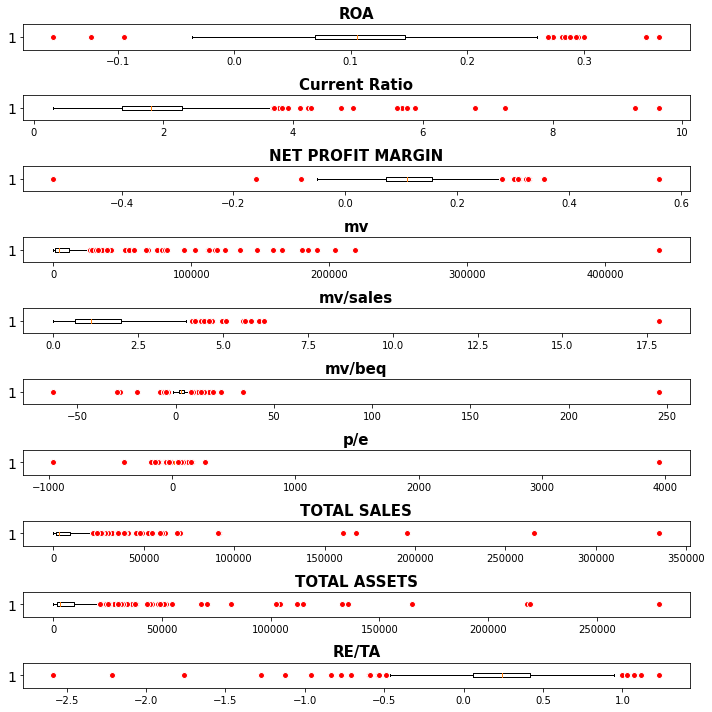

In [48]:
#Creating boxplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

fig, axs = plt.subplots(len(df_model.columns),1, figsize=(10,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df_model.iloc[:,i], flierprops=red_circle, meanprops=mean_shape, vert = False)
    ax.set_title(df_model.columns[i], fontsize=15, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

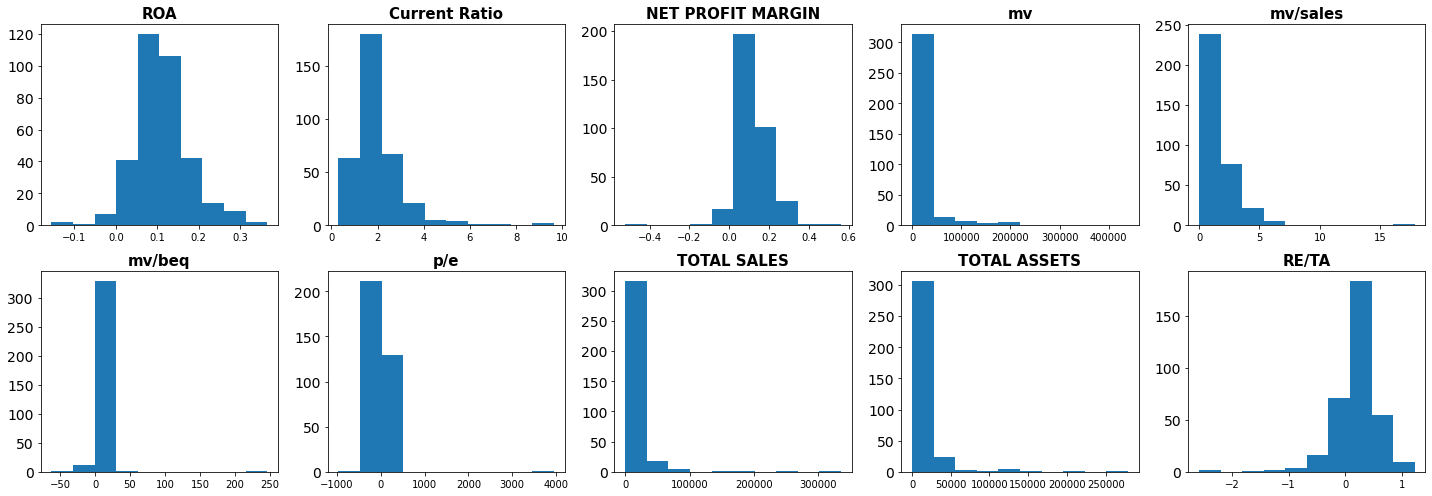

In [49]:
#Creating histogram of each column with its own scale
fig, axs = plt.subplots(2,5, figsize=(20,7))

for i, ax in enumerate(axs.flat):
    ax.hist(df_model.iloc[:,i])
    ax.set_title(df_model.columns[i], fontsize=15, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

In [50]:
df_model.describe()


,ROA,Current Ratio,NET PROFIT MARGIN,mv,mv/sales,mv/beq,p/e,TOTAL SALES,TOTAL ASSETS,RE/TA
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.110642,2.017150,0.116752,17059.179978,1.547113,3.589750,24.025285,11856.471017,12685.247221,0.203097
std,0.067413,1.106279,0.082952,40655.784292,1.496501,14.269730,222.542586,30337.188742,29664.799449,0.400364
min,-0.155169,0.304163,-0.521880,0.017823,0.000014,-62.216453,-964.287735,84.209000,156.741000,-2.583596
25%,0.069420,1.363975,0.071748,1494.008200,0.646135,1.757390,9.872734,1497.479000,1604.782500,0.058042
50%,0.104978,1.805532,0.109695,3783.874905,1.113466,2.803554,17.075702,3425.340500,3347.255000,0.239480
75%,0.146757,2.291817,0.154258,11230.357020,1.991899,4.217032,22.231953,9333.922000,9573.700000,0.419417
max,0.364702,9.643438,0.560904,439013.270000,17.853070,246.084854,3953.541714,335086.000000,278554.000000,1.232304


- According to the multiple box plots above, every column has outliers and most of them have only several anomalies and it is not a big issue.

- However, "market value", 'total assets', 'total sales' and "market value / book equity" have more outliers compared to others

- Since, we only have 344 data points, dropping some outliers may decrease the model predictive power

- I will use Winsorization and Log transformation methods to deal with outliers and compare the predictive power later

###  Winsorization Method

In [51]:
from scipy.stats.mstats import winsorize
df_win = df_model
col_name_win = df_win.columns

In [52]:
# WINSORIZE within the range of 1% and 98% quantiles
df_win = winsorize(df_win, (0.01, 0.02))
df_win = pd.DataFrame(df_win, columns = col_name_win )
df_win.describe()

,ROA,Current Ratio,NET PROFIT MARGIN,mv,mv/sales,mv/beq,p/e,TOTAL SALES,TOTAL ASSETS,RE/TA
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.110642,2.017150,0.116752,10302.423549,1.547113,3.922330,30.750842,8634.719782,9061.664820,0.203097
std,0.067413,1.106279,0.082952,13807.179415,1.496501,13.573103,213.830646,11880.332085,12414.870027,0.400364
min,-0.155169,0.304163,-0.521880,0.017823,0.000014,-6.711166,-6.711166,84.209000,156.741000,-2.583596
25%,0.069420,1.363975,0.071748,1494.008200,0.646135,1.757390,9.872734,1497.479000,1604.782500,0.058042
50%,0.104978,1.805532,0.109695,3783.874905,1.113466,2.803554,17.075702,3425.340500,3347.255000,0.239480
75%,0.146757,2.291817,0.154258,11230.357020,1.991899,4.217032,22.231953,9333.922000,9573.700000,0.419417
max,0.364702,9.643438,0.560904,45581.000000,17.853070,246.084854,3953.541714,45581.000000,45581.000000,1.232304


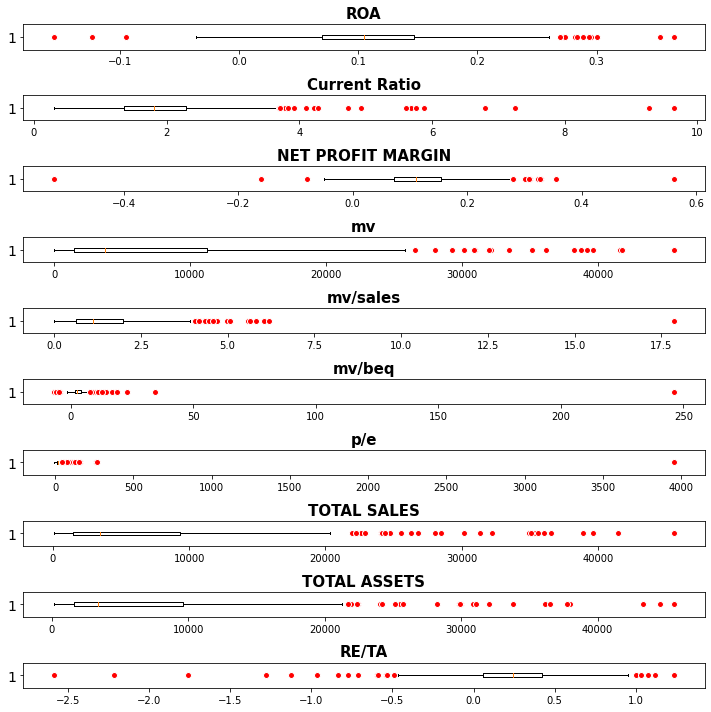

In [53]:
#Check the outlier after winsorization
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

fig, axs = plt.subplots(len(df_win.columns),1, figsize=(10,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df_win.iloc[:,i], flierprops=red_circle, meanprops=mean_shape, vert = False)
    ax.set_title(df_win.columns[i], fontsize=15, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

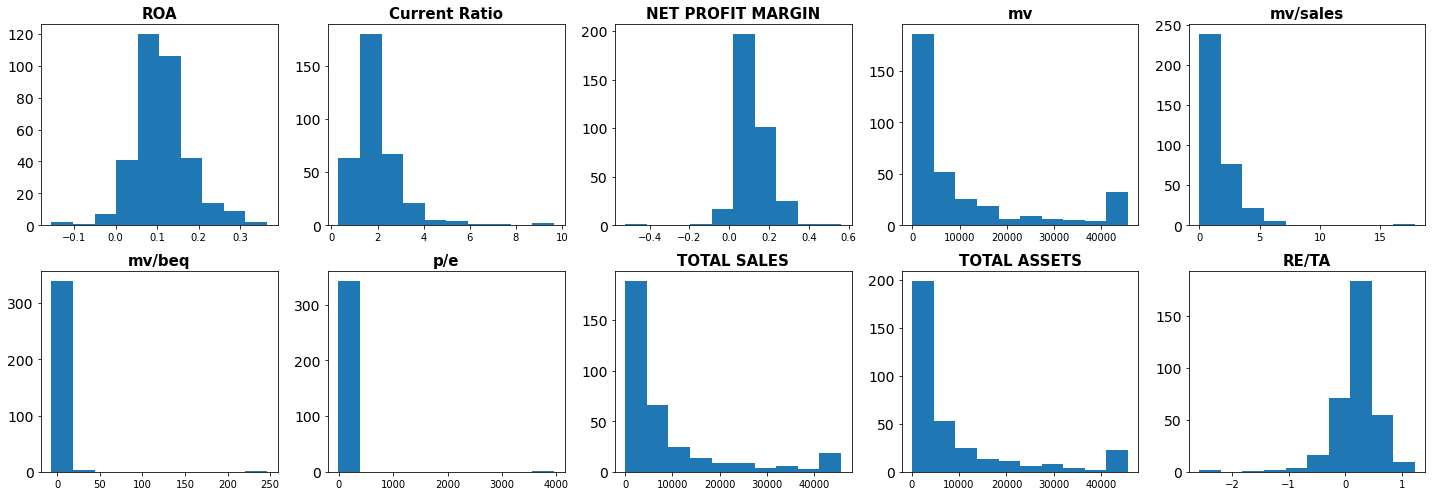

In [54]:
#Check the outliers after Winsorization Method
fig, axs = plt.subplots(2,5, figsize=(20,7))

for i, ax in enumerate(axs.flat):
    ax.hist(df_win.iloc[:,i])
    ax.set_title(df_win.columns[i], fontsize=15, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

### Log Tranformation Method + Winsorization Method

In [65]:
df_logwin =pd.DataFrame()
df_logwin

""


In [66]:
df_model.columns

Index(['ROA', 'Current Ratio', 'NET PROFIT MARGIN', 'mv', 'mv/sales', 'mv/beq',
       'p/e', 'TOTAL SALES', 'TOTAL ASSETS', 'RE/TA'],
      dtype='object')

In [67]:
win_col = []
log_col = []
for i in df_model.columns:
  if df_model[i].min() > 0:
    df_logwin[i+'_win'] = np.log(df_model[i])
    win_col.append(i)
  else:
    df_logwin[i+'_log'] = winsorize(df_model[i], (0.01, 0.02))
    log_col.append(i)

print(win_col,'\n', log_col)

['Current Ratio', 'mv', 'mv/sales', 'TOTAL SALES', 'TOTAL ASSETS'] 
 ['ROA', 'NET PROFIT MARGIN', 'mv/beq', 'p/e', 'RE/TA']


In [74]:
df_logwin

,ROA_log,Current Ratio_win,NET PROFIT MARGIN_log,mv_win,mv/sales_win,mv/beq_log,p/e_log,TOTAL SALES_win,TOTAL ASSETS_win,RE/TA_log
0,0.074407,1.013164,0.086026,6.782378,0.469109,1.808937,32.722445,6.313269,6.458373,0.149326
1,0.134341,-0.057633,0.216237,11.223630,1.203413,5.327886,43.616653,10.020218,10.496211,0.275262
2,0.030501,0.328981,0.070986,9.317530,0.678296,1.924192,-67.056928,8.639234,9.483949,0.035293
3,0.090647,0.117314,0.114515,9.633541,0.545323,3.100812,21.106442,9.088218,9.321944,0.493869
4,0.114541,0.193930,0.112985,10.497333,0.143821,3.726212,17.387797,10.353512,10.339837,0.363789
...,...,...,...,...,...,...,...,...,...,...
339,0.077245,0.817594,0.067215,-1.105033,-7.937846,0.001203,0.022552,6.832813,6.693733,0.089344
340,0.035451,0.548125,0.148602,8.149807,1.523809,2.607008,-22.556912,6.625998,8.059132,-0.224130
341,0.096929,0.327812,0.099828,10.575869,0.473039,6.488562,28.185564,10.102830,10.132295,0.064752
342,-0.036043,0.697936,-0.051005,7.199338,0.586824,-4.704222,-5.837268,6.612514,6.646459,-0.441155


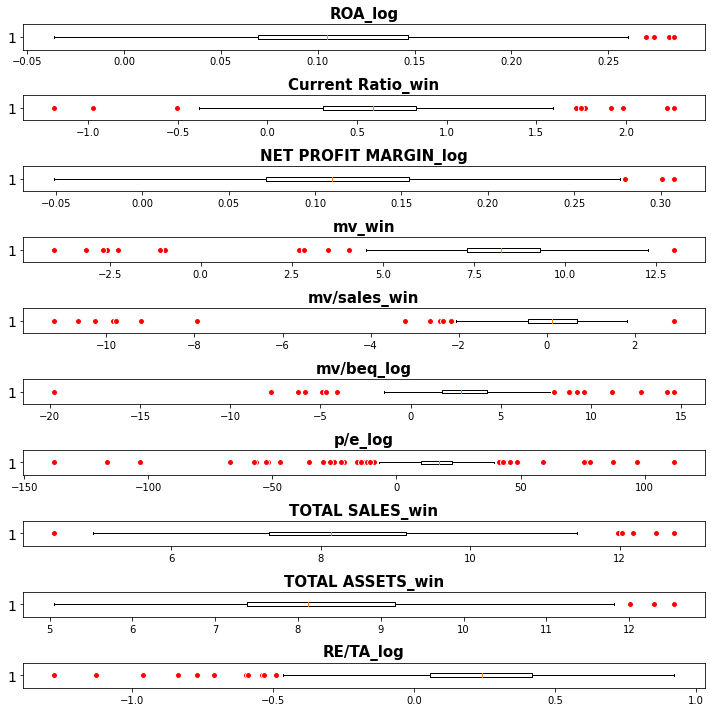

In [75]:
#Check the outlier after Log Transformation
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

fig, axs = plt.subplots(len(df_logwin.columns),1, figsize=(10,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df_logwin.iloc[:,i], flierprops=red_circle, meanprops=mean_shape, vert = False)
    ax.set_title(df_logwin.columns[i], fontsize=15, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

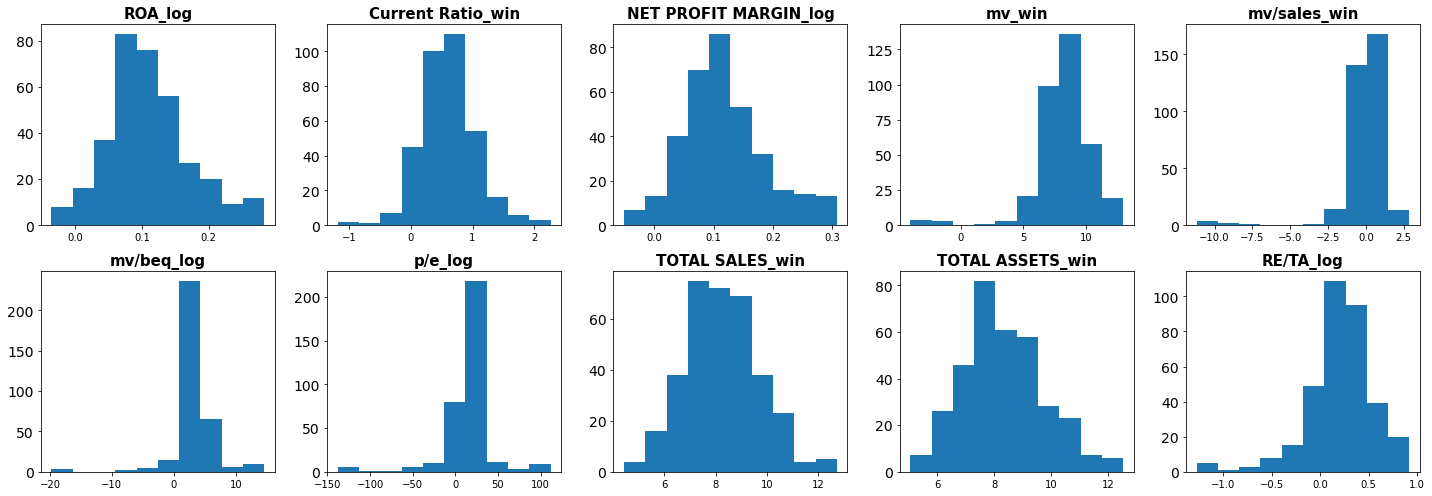

In [76]:
#Check the outlier after Log Transformation
fig, axs = plt.subplots(2,5, figsize=(20,7))

for i, ax in enumerate(axs.flat):
    ax.hist(df_logwin.iloc[:,i])
    ax.set_title(df_logwin.columns[i], fontsize=15, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

### Summary

From the eyeball test, Combining Log transformation and Winsorization together did a better job on dealing with the outliers, since both the boxplots and histograms plotted after both methods show a normal distribution for each financial feature. But, we will still need to use the model result, such as adjusted R2 to compare which method is better on handling the outliers.

# Linear Regression Model

## Model (Winsorization)

In [77]:
df_model_win = pd.concat([df_win, df['CREDIT_RATING']], axis = 1)

In [78]:
df_model_win['constant'] = 1 # intercept

In [79]:
X = df_model_win.drop(columns = 'CREDIT_RATING')
y = df_model_win['CREDIT_RATING']

In [80]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          CREDIT_RATING   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     66.48
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           2.98e-73
Time:                        20:36:08   Log-Likelihood:                -734.72
No. Observations:                 344   AIC:                             1491.
Df Residuals:                     333   BIC:                             1534.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
ROA                   1.8320      2.70

## Model (Log Transformation + Winsorization)

In [81]:
df_model_logwin = pd.concat([df_logwin, df['CREDIT_RATING']], axis = 1)

In [82]:
df_model_logwin['constant'] = 1 # intercept

In [83]:
X2 = df_model_logwin.drop(columns = 'CREDIT_RATING')
y2 = df_model_logwin['CREDIT_RATING']

In [84]:
model2 = sm.OLS(y2, X2)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:          CREDIT_RATING   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     94.53
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           2.53e-86
Time:                        20:36:15   Log-Likelihood:                -705.71
No. Observations:                 344   AIC:                             1431.
Df Residuals:                     334   BIC:                             1470.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ROA_log                   3.09

# Conclusion

* Both Linear Regression Models selected the same 10 independent varibales, but only differenece is that one applied winsorization only to deal with outliers and the other chose the log transformation and winsorization together to handle anomalies. Based on the R2 and AdjR2, we found that the model using log transformation and winsorization with (R2 = 0.718 > 0.666 and AdjR2 = 0.710 > 0.656)indicates a better fit and 71.8% of credit rating could be explained by those 10 independent varibales.

* For the second Model, The coefficients of *market value*, *LOG_market price over book equity value*, *LOG_retained earning over total assets* are statistically significant at 5%. In addition, *t-values* for all three independent variables are 2.092, 2.897, 7.782, respectively and all more than 1.96, which also proves that coefficients for those 3 variables are significant different from 0 at 5% level.

* **On average, for each dollar increase in *market value*, the credit rating will increase 0.3303 (On average, for 1% dollar increase in *market value*, the credit rating will increase [0.3303 / 100 = 0.003]**

* **On average, for each 10% increase in *market price over book value*, the credit rating will increase [0.0104 * log(1.10) = 0.099%]**

* **On average, for each 1% increase in *retained earning over total assets*, the credit rating will increase [2.8181 / 100 = 0.028]**

* In sum, **the ratio of *retained earning over total assets* will have more impact on the credit rating prediction**, since the main reason is RE / TA could be a good indicator of companies' profitbaility in the future. For instance, low RE/TA suggests that companies are financing capital expenditure via borrowings rather than retained earnings.

# Appendix

```
-  Y = β0 + β1*log(X)

- (β0 + β1*log(1.01)) – (β0 + β1*log1)

- β1*log(1.01) – β1*log1

- β1*(log(1.01) – log1)

- β1*log(1.01 / 1) = β1*log(1.01)

The result is multiplying the slope coefficient by log(1.01), which is approximately equal to 0.01, or  1/100
```

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [98]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/BA_870/HW/2/Assignment2_Ji_Qi.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/BA_870/HW/2/Assignment2_Ji_Qi.ipynb to pdf
[NbConvertApp] Support files will be in Assignment2_Ji_Qi_files/
[NbConvertApp] Making directory ./Assignment2_Ji_Qi_files
[NbConvertApp] Making directory ./Assignment2_Ji_Qi_files
[NbConvertApp] Making directory ./Assignment2_Ji_Qi_files
[NbConvertApp] Making directory ./Assignment2_Ji_Qi_files
[NbConvertApp] Making directory ./Assignment2_Ji_Qi_files
[NbConvertApp] Making directory ./Assignment2_Ji_Qi_files
[NbConvertApp] Writing 114323 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 296825 bytes to /content/drive/MyDrive/BA_870/HW/2/Assignment2_Ji_Qi.pdf
